## 1. Wczytanie i skalowanie wartości pikseli obrazu

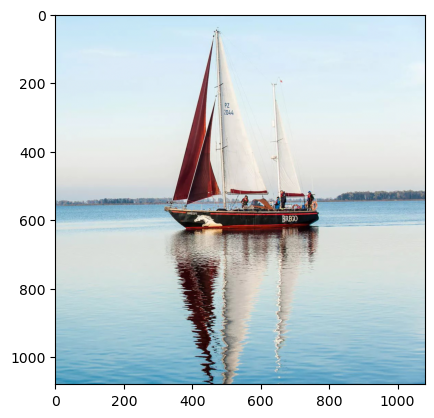

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

brego_image = cv2.imread('brego-full-crop.jpg')

brego_image_rgb = cv2.cvtColor(brego_image, cv2.COLOR_BGR2RGB) / 255.0

plt.imshow(brego_image_rgb)
plt.show()

## 2. Konwersja obrazu na skalę szarości

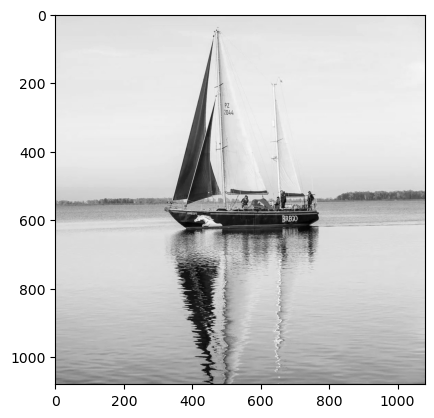

In [24]:
greyscale_kernel = np.array([0.4, 0.3, 0.3])

brego_image_gs = np.dot(brego_image_rgb, greyscale_kernel)

plt.imshow(brego_image_gs, cmap='gray', vmin=0, vmax=1)
plt.show()


## 3. Pooling - redukcja rozmiaru

[[0.85294118 0.85294118 0.85294118 ... 0.87960784 0.87960784 0.87960784]
 [0.85294118 0.85294118 0.85294118 ... 0.87960784 0.87960784 0.87960784]
 [0.85294118 0.85294118 0.85294118 ... 0.87960784 0.87960784 0.87960784]
 ...
 [0.54156863 0.54156863 0.53764706 ... 0.49176471 0.49176471 0.48862745]
 [0.54156863 0.54156863 0.53764706 ... 0.48313725 0.4827451  0.4827451 ]
 [0.54156863 0.54156863 0.53764706 ... 0.48666667 0.48666667 0.48666667]]
